In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [4]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [5]:
data = pd.read_csv('final-data.csv')

In [6]:
data['Week Endings'] = pd.to_datetime(data['Week Endings'], errors = 'raise')
data = data.sort_values(by='Week Endings', ascending=True)

In [7]:
# Truncating data after the release of the lion king movie
lk_release = datetime.date(2019, 7, 19)
boolean_mask = data['Week Endings'].dt.date < lk_release

In [8]:
# Data after the series has been truncated
print(data[boolean_mask].tail(5).to_string())
print(data[boolean_mask].shape)

    Week Endings  Avg Ticket Price ($)  Top Ticket Price ($)  Seats Sold  Seats in Theatre   % Cap
141   2019-06-16                171.79                 225.0       13565              1696   99.98
140   2019-06-23                178.53                 225.0       13569              1696  100.01
139   2019-06-30                179.18                 225.0       13550              1696   99.87
138   2019-07-07                190.91                 225.0       13519              1696   99.64
137   2019-07-14                187.67                 225.0       12759              1696   94.04
(1129, 6)


In [9]:
data = data[boolean_mask]

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1129 entries, 1265 to 137
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Week Endings          1129 non-null   datetime64[ns]
 1   Avg Ticket Price ($)  1129 non-null   float64       
 2   Top Ticket Price ($)  1129 non-null   float64       
 3   Seats Sold            1129 non-null   int64         
 4   Seats in Theatre      1129 non-null   int64         
 5   % Cap                 1129 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 61.7 KB


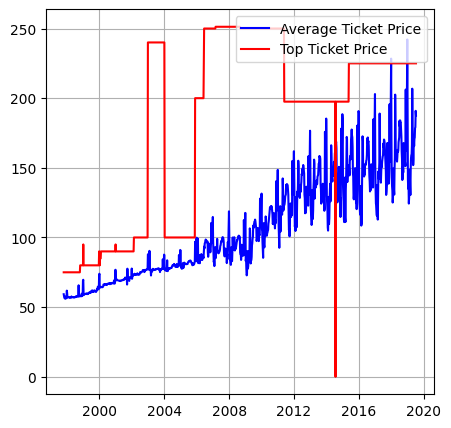

In [11]:
# Some basic plotting to check data and 
# data scale to determine whether data needs to be normalised or not
# before being used with the sequence model for prediction
# year = np.array(range(data.shape[0])) + 757
time = data['Week Endings']
plt.figure(figsize=(5, 5))
plt.grid(True)
plt.plot(time, data['Avg Ticket Price ($)'], color='b', label="Average Ticket Price")
plt.plot(time, data['Top Ticket Price ($)'], color='r', label="Top Ticket Price")
plt.legend(loc=1)
plt.show()

In [12]:
series = data['Avg Ticket Price ($)']
split_time = int(len(series) * 0.85)

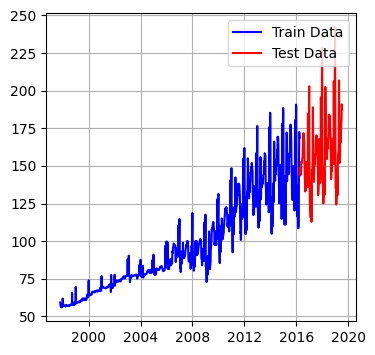

In [13]:
x_train = series[:split_time]
time_train = time[:split_time]
x_valid = series[split_time:]
time_valid = time[split_time:]

plt.figure(figsize=(4, 4))
plt.grid(True)
plt.plot(time_train, x_train, color='b', label="Train Data")
plt.plot(time_valid, x_valid, color='r', label="Test Data")
plt.legend(loc=1)
plt.show()

# Utilities:

In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [127]:
# Defining parameters
window_size = 20
batch_size = 8
shuffle_buffer = 1000

In [128]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer)

In [129]:
# Checking the windowed training set:
list(train_set.take(2).as_numpy_iterator())

[(array([[ 60.85,  60.19,  60.14,  60.48,  60.68,  61.58,  61.13,  62.  ,
           61.17,  61.15,  61.82,  61.16,  60.91,  61.61,  61.69,  62.03,
           61.53,  61.54,  61.11,  61.04],
         [ 85.4 , 104.66, 110.3 ,  94.99,  92.9 ,  99.47, 100.56, 102.17,
          115.09, 114.07, 105.08, 105.55, 101.26, 102.99, 103.7 , 104.85,
          105.42, 109.95, 111.49, 113.86],
         [ 77.69,  70.35,  72.37,  72.29,  72.87,  73.39,  73.24,  73.12,
           73.33,  73.95,  73.4 ,  73.52,  73.2 ,  73.2 ,  73.3 ,  73.21,
           73.25,  73.64,  74.26,  73.46],
         [ 77.83,  77.49,  77.48,  77.44,  78.04,  78.04,  78.02,  78.25,
           78.25,  78.07,  78.65,  79.15,  79.99,  80.13,  79.81,  80.16,
           80.08,  81.04,  80.27,  80.29],
         [148.77, 145.98, 130.67, 128.27, 117.37, 120.87, 117.66, 119.27,
          136.46, 132.93, 129.2 , 126.3 , 126.55, 123.04, 122.86, 158.43,
          130.72, 139.26, 141.16, 158.68],
         [157.61, 142.63, 142.27, 140.17, 147

In [130]:
# Creating the validation dataset
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer)

In [131]:
# Resetting any prior defined model weight data
tf.keras.backend.clear_session()

# Defining the model
l0 = tf.keras.layers.Dense(1)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=[window_size]),
    l0
])

In [132]:
print(l0.get_weights())

[array([[-0.40365976],
       [ 0.7232956 ],
       [ 0.5585204 ],
       [-0.39503306],
       [ 0.4494967 ],
       [-0.20970803],
       [-0.69733703],
       [-0.5911201 ],
       [-0.72403085],
       [-0.6140852 ]], dtype=float32), array([0.], dtype=float32)]


In [133]:
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.4),
    metrics=['mae'])

In [134]:
# Training Parameters
epochs = 200

In [135]:
# Learning Rate Scheduler (Exponential Decay)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * (10 ** (epoch / 20))
)

In [136]:
history = model.fit(train_set, epochs=epochs, validation_data=valid_set)

Epoch 1/200


118/118 [==============================] - 1s 3ms/step - loss: 70.3833 - mae: 70.8680 - val_loss: 16.0693 - val_mae: 16.5541
Epoch 2/200
118/118 [==============================] - 0s 2ms/step - loss: 6.1270 - mae: 6.5786 - val_loss: 15.1429 - val_mae: 15.6380
Epoch 3/200
118/118 [==============================] - 0s 2ms/step - loss: 5.9401 - mae: 6.3926 - val_loss: 14.8598 - val_mae: 15.3568
Epoch 4/200
118/118 [==============================] - 0s 2ms/step - loss: 5.8415 - mae: 6.2917 - val_loss: 14.7278 - val_mae: 15.2245
Epoch 5/200
118/118 [==============================] - 0s 2ms/step - loss: 5.8088 - mae: 6.2607 - val_loss: 14.5863 - val_mae: 15.0845
Epoch 6/200
118/118 [==============================] - 0s 2ms/step - loss: 5.8045 - mae: 6.2528 - val_loss: 14.4701 - val_mae: 14.9665
Epoch 7/200
118/118 [==============================] - 0s 2ms/step - loss: 5.7368 - mae: 6.1858 - val_loss: 14.4876 - val_mae: 14.9753
Epoch 8/200
118/118 [==============================] - 0s 2ms/ste

In [137]:
hist = history.history
loss = hist['loss']
val_loss = hist['val_loss']
mae = hist['mae']
val_mae = hist['val_mae']
epoch_life = range(len(loss))

In [138]:
# # Learning Rate Scheduler plot
# lr = hist['lr']
# plt.semilogx(lr[0:40], loss[0:40])
# plt.xlabel("Learning Rate")
# plt.ylabel("Loss")
# plt.title("Learning Rate Scheduler Helper")
# plt.grid(True)
# plt.show()

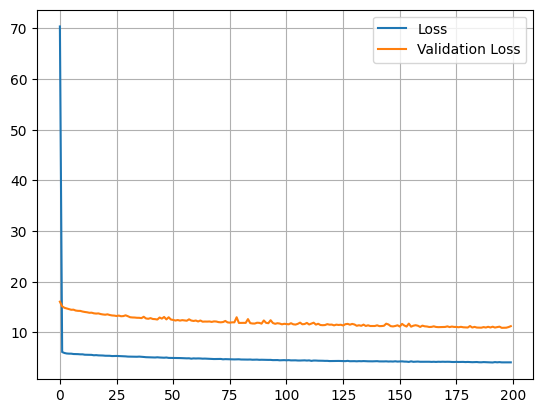

In [139]:
plt.plot(epoch_life, loss, label="Loss")
plt.plot(epoch_life, val_loss, label="Validation Loss")
plt.legend(loc=1)
plt.grid(True)
plt.show()

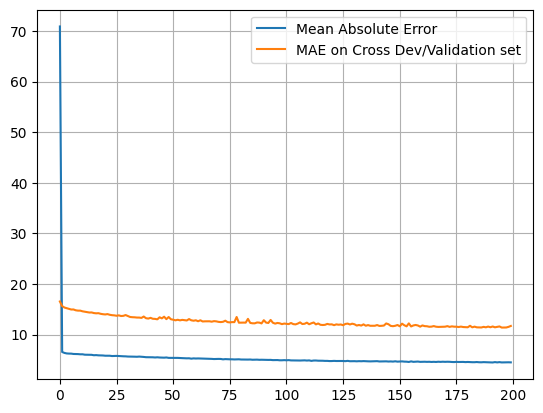

In [140]:
plt.plot(epoch_life, mae, label="Mean Absolute Error")
plt.plot(epoch_life, val_mae, label="MAE on Cross Dev/Validation set")
plt.grid(True)
plt.legend(loc=1)
plt.show()

In [141]:
# Checking layer weights:
print(l0.get_weights())

[array([[-0.40365976],
       [ 0.7232956 ],
       [ 0.5585204 ],
       [-0.45864305],
       [ 0.5760484 ],
       [-0.06798548],
       [-0.69733703],
       [-0.546261  ],
       [-0.7405175 ],
       [-0.6140852 ]], dtype=float32), array([0.00152953], dtype=float32)]


In [142]:
series = np.array(series)

In [143]:
# Checking out by forecasting for 1 window
start = split_time - window_size
output = model.predict(series[start:split_time][np.newaxis])
print("Actual Price: ${}".format(series[split_time]))
print("Predicted Price: ${}".format(output.squeeze()))

1/1 [==============================] - 0s 54ms/step
Actual Price: $148.38
Predicted Price: $166.198486328125


In [144]:
def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset)
    
    return forecast

In [145]:
series_to_forecast = series[split_time-window_size:-1]
forecast = model_forecast(model, series_to_forecast, window_size, batch_size)
forecast = np.squeeze(forecast)

22/22 [==============================] - 0s 2ms/step


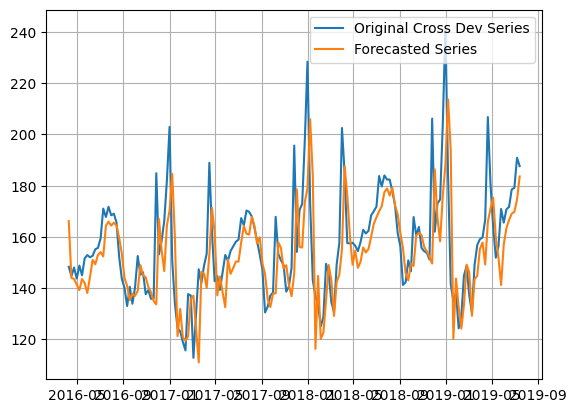

Mean Absolute Error for Forecasted Series: 11.09271240234375


In [146]:
plt.plot(time_valid, x_valid, label="Original Cross Dev Series")
plt.plot(time_valid, forecast, label="Forecasted Series")
plt.legend(loc=1)
plt.grid(True)
plt.show()

print("Mean Absolute Error for Forecasted Series: {}".format(tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()))

### Chores: 
To perform sanity check, normalize data, and optionally set a benchmark for the model using statistical methods